<a href="https://colab.research.google.com/github/HemiaoZhang/CEE316Project/blob/main/1_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/signedDistance.mat'
img_bi = []
img_sd = []
with h5py.File(path, 'r') as file:
  img_bi = np.array(file['img_bi'][:]) # instancex512x512
  img_sd = np.array(file['img_sd'][:]) # instancex512x512

/content/gdrive/MyDrive/Colab Notebooks/CEE316
/content/gdrive/MyDrive/Colab Notebooks/CEE316


[PCA and SVD](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

In [3]:
def pca(X, n=50):
  '''
  take in flattened vector representation of image with size (ninstance, widthxwidth),
  plot up to n-th largest explained variance ratios, and
  return up to n-th largest eigenvalues and eigenvectors
  '''
  X = X - np.tile(np.mean(X, axis=0), (X.shape[0],1))
  Cov = np.cov(X.T) # numpy take different vectors row-wise
  sz = Cov.shape[0]
  L, V = scipy.linalg.eigh(Cov, subset_by_index=[sz-n, sz-1]) # largest n lambda and principal axes
  Var = L / L.sum() # explained variance ratio

  #idx = np.argpartition(Var, -n)[-n:] # n-th largest
  #idx = idx[np.argsort(-Var[idx])] # sorted in descending order
  idx = np.argsort(-Var) # sorted in descending order

  plt.figure(figsize=(20, 5))
  plt.bar(range(len(Var)), Var[idx])
  plt.title(f'percentage of {n}-th largest explained variance ratio')

  return L[idx], V[:,idx]

In [4]:
from numpy.ma.core import shape
def reconstruct(x, V):
  '''
  reconstruct a compressed image collaped into subspace of
  n=len(L) principal axes
  @x size (wxw,)
  @V size (wxw, n), first n-th eigenvectors
  '''
  proj = np.matmul(x, V) # projection of x onto the subspace
  recon = np.zeros_like(x)
  for i in range(len(L)):
    recon += np.multiply(proj[i], V[:,i])
  return recon

Since 512x512=262144 results in a covariance matrix of size 262144-by-262144, which is very expensive to get up to n-th eigenvalues, only a portion of the sample domain w-by-w (even 256 is too large)

### Binary image

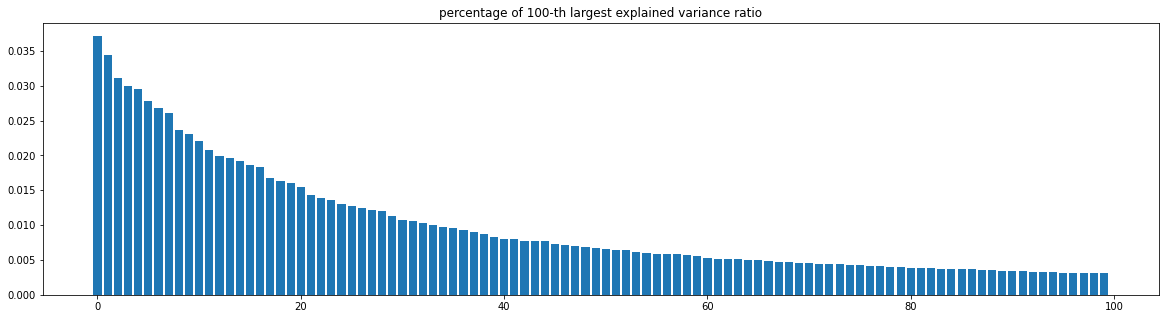

In [5]:
w = 128 # width of a subsection of the image
subimg = img_bi[:,:w,:w].reshape(-1, w*w) # size: instance, (wxw)
d, v = pca(subimg, n=100)

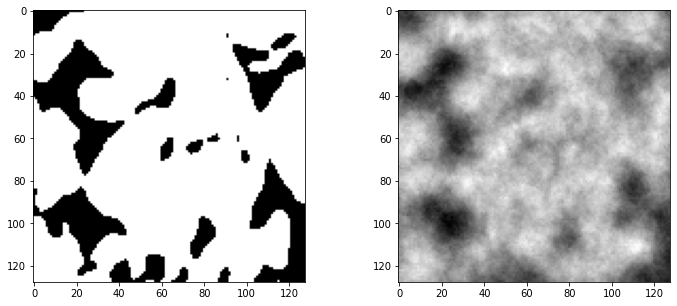

In [6]:
x = subimg[0,:]
x_hat = reconstruct(x, v)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(w,w), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_hat.reshape(w,w), cmap='gray')

### Image after signed distance transformation

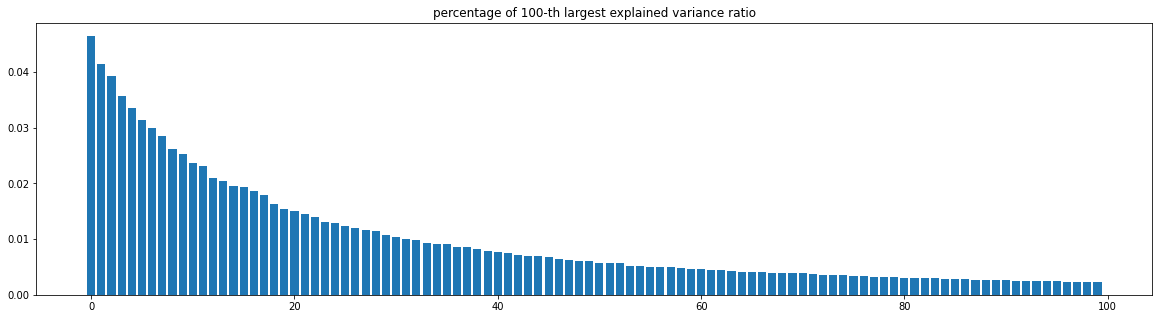

In [7]:
w = 128 # width of a subsection of the image
subimg = img_sd[:,:w,:w].reshape(-1, w*w) # size: instance, (wxw)
d, v = pca(subimg, n=100)

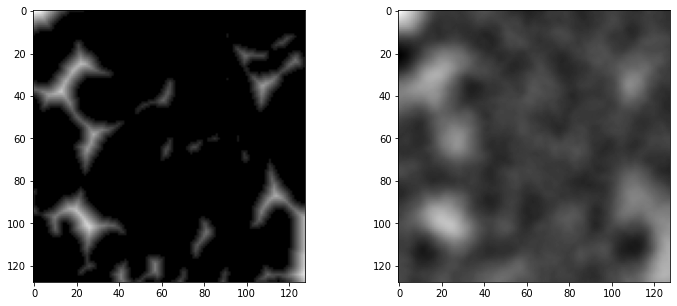

In [8]:
x = subimg[0,:]
x_hat = reconstruct(x, v)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(w,w), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_hat.reshape(w,w), cmap='gray')

In [9]:
# end runtime
from google.colab import runtime

In [ ]:
runtime.unassign()